In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests as rq
import re



In [2]:
# Read CSV file into a Pandas DataFrame
df_kaggle = pd.read_csv('../kaggle/the_oscar_award.csv')

# # Change column values based on conditions
# df_kaggle.loc[df_kaggle['Winner'] == 1, 'Winner'] = True
# df_kaggle.loc[df_kaggle['Winner'].isna(), 'Winner'] = False

#removing everything that appears in ()
#define a regular expression to match parentheses and their contents
pattern = r'\s*\([^)]*\)'

# remove parentheses and their contents from column 'A'
df_kaggle['category'] = df_kaggle['category'].replace(pattern, '', regex=True)

def clean_string(s):
    s= s.title()
    # use regular expressions to match words with multiple capital letters
    pattern = r'\b\w*[A-Z]+\w*\b'
    matches = re.findall(pattern, s)
    for match in matches:
        # convert the matched word to lowercase except for the first letter
        s = s.replace(match, match.capitalize())
    return s

df_kaggle['category'] = df_kaggle['category'].apply(clean_string)

In [3]:
# filter out rows containing 'Award' in the Category column
df_kaggle = df_kaggle[~df_kaggle['category'].str.contains('Award')]

#at first Best Picture Award was called Outstanding Picture and Unique and Artistic Picture
df_kaggle['category'] = df_kaggle['category'].replace(['Outstanding Picture', 'Unique And Artistic Picture', 'Outstanding Motion Picture', 'Best Motion Picture', 'Outstanding Production'], 'Best Picture')


#Actor award was changed to Actor in a Leading Role in 1976 I'm leaving it as Actor
df_kaggle['category'] = df_kaggle['category'].replace('Actor In A Leading Role', 'Actor')
df_kaggle['category'] = df_kaggle['category'].replace('Actress In A Leading Role', 'Actress')

# Best Art Direction changed to Best Production Design in 2012
df_kaggle['category'] = df_kaggle['category'].replace('Art Direction', 'Production Design')

df_kaggle['category'] = df_kaggle['category'].replace('Makeup', 'Makeup And Hairstyling')

df_kaggle['category'] = df_kaggle['category'].replace('Foreign Language Film', 'International Feature Film')

# create boolean mask for rows containing target strings
mask = df_kaggle['category'].str.contains('Sound')
# replace values in rows matching the mask with the desired string
df_kaggle.loc[mask, 'category'] = 'Sound'

# create boolean mask for rows containing target strings
mask2 = df_kaggle['category'].str.contains('Effects')
# replace values in rows matching the mask with the desired string
df_kaggle.loc[mask2, 'category'] = 'VFX'

# out of Documentary category in 2022 Documentary Feature Film and Documentary Short Film emerged - im changing it to documentary

df_kaggle['category'] = df_kaggle['category'].replace(['Documentary Short Film', 'Documentary Feature Film'], 'Documentary')




In [4]:
#nominated and winners of best picture award Oscars from 1927 (year, title, wiki, winner(T/F))
osc_scrape = pd.read_csv('../data/scraping_results/osc_bp.csv')
osc_scrape['film'] = osc_scrape['film'].apply(lambda x: x.strip())
# Filter the DataFrame based on a column value
ocs_winners = osc_scrape[osc_scrape['winner'] == True].drop('winner', axis=1)


In [5]:
#function that keeps only the main categories of nominations
def main_noms(df):
    general_cats = ['Writing', 'Best Picture', 'Acting', 'Directing', 'Film Editing', 'Music', 'Cinematography', 'Sound', 'Production Design', 'Costume', 'Makeup and Hairstyling', 'VFX']
    df['category'] = df['category'].replace(['Actor', 'Actress', 'Actor In A Supporitng Role', 'Actress In A Supporitng Role'], 'Acting')
    df_main_noms = df[df['category'].isin(general_cats)]
    return df_main_noms


In [6]:
#function that keeps only the main categories of nominations
def main_noms_gender(df):
    general_cats = ['Writing', 'Best Picture', 'Actor', 'Actress','Directing', 'Film Editing', 'Music', 'Cinematography', 'Sound', 'Production Design', 'Costume', 'Makeup and Hairstyling', 'VFX']
    df['category'] = df['category'].replace(['Actor','Actor In A Supporitng Role'], 'Actor')
    df['category'] = df['category'].replace(['Actress','Actress In A Supporitng Role'], 'Actress')
    df_main_noms = df[df['category'].isin(general_cats)]
    return df_main_noms

In [7]:

df_all_noms = df_kaggle[df_kaggle['film'].isin(osc_scrape['film'])].copy().drop(['name', 'year_ceremony'], axis=1).rename(columns={'year_film': 'year'})
all_quiet= df_all_noms[df_all_noms['film']=='All Quiet on the Western Front']
all_quiet_2022 = all_quiet[all_quiet['year'] == 2022].groupby('film')['category'].agg(list).apply(lambda x: ', '.join(x)).reset_index()
all_quiet_2022.insert(0, 'year', '2022')
all_quiet_2022


,year,film,category
0,2022,All Quiet on the Western Front,"Cinematography, International Feature Film, Ma..."


In [8]:
print(type(all_quiet_2022))

<class 'pandas.core.frame.DataFrame'>


In [9]:
df_all_noms = df_kaggle[df_kaggle['film'].isin(osc_scrape['film'])].copy().drop(['name', 'year_ceremony'], axis=1).rename(columns={'year_film': 'year'})
# im creating a separate df which consists of generalised nominations - all acting into one, got rid of animation, international, short and documenatry
df_filtered_noms=main_noms(df_all_noms)

# Group by 'Film' and aggregate other columns
df_grouped = df_filtered_noms.groupby('film').agg({'year': 'first', 'category': lambda x: ','.join(x)})

# Accounting for the fact that there is two all quiet on the western front films
all_quiet= df_all_noms[df_all_noms['film']=='All Quiet on the Western Front']
all_quiet_2022 = all_quiet[all_quiet['year'] == 2022].groupby('film')['category'].agg(list).apply(lambda x: ', '.join(x)).reset_index()
all_quiet_2022.insert(0, 'year', '2022')
all_quiet_2022

# Create one-hot encoded columns for categories
categories = df_filtered_noms['category'].unique()
for category in categories:
    df_grouped[category] = df_grouped['category'].str.contains(category).astype(int)

for category in categories:
    all_quiet_2022[category] = all_quiet_2022['category'].str.contains(category).astype(int)


# Drop the 'Category' column
df_grouped = df_grouped.drop('category', axis=1)
all_quiet_2022 = all_quiet_2022.drop('category', axis=1)

# Reset the index
df_grouped = df_grouped.sort_values('year').reset_index()
merged_df1 = pd.concat([df_grouped, all_quiet_2022], axis=0)
merged_df = pd.merge(osc_scrape,merged_df1,  on='film', how='inner').drop(['year_y', 'Best Picture'], axis=1).rename(columns={'year_x': 'year'})

merged_df[merged_df['film']=='All Quiet on the Western Front']
merged_df=merged_df.sort_values('year')
merged_df.tail(10)


,year,film,wiki,winner,Acting,Production Design,Directing,VFX,Writing,Cinematography,Sound,Film Editing,Music
570,2022,Top Gun: Maverick,/wiki/Top_Gun:_Maverick,False,0,0,0,1,1,0,1,1,1
569,2022,Tár,/wiki/T%C3%A1r,False,1,0,1,0,1,1,0,1,0
567,2022,Elvis,/wiki/Elvis_(2022_film),False,1,1,0,0,0,1,1,1,0
11,2022,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(2022_film),False,0,1,0,1,1,1,1,0,1
565,2022,Avatar: The Way of Water,/wiki/Avatar:_The_Way_of_Water,False,0,1,0,1,0,0,1,0,0
564,2022,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once,True,1,0,1,0,1,0,0,1,1
10,2022,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(2022_film),False,0,1,1,1,1,1,1,0,1
571,2022,Triangle of Sadness,/wiki/Triangle_of_Sadness,False,0,0,1,0,1,0,0,0,0
566,2022,The Banshees of Inisherin,/wiki/The_Banshees_of_Inisherin,False,1,0,1,0,1,0,0,1,1
572,2022,Women Talking,/wiki/Women_Talking_(film),False,0,0,0,0,1,0,0,0,0


In [10]:
merged_df.to_csv('../data/processed_results//osc_bp_noms.csv')

In [11]:
df_all_noms = df_kaggle[df_kaggle['film'].isin(osc_scrape['film'])].copy().drop(['name', 'year_ceremony'], axis=1).rename(columns={'year_film': 'year'})
# im creating a separate df which consists of generalised nominations - all acting into one, got rid of animation, international, short and documenatry
df_gender_noms=main_noms_gender(df_all_noms)

# Group by 'Film' and aggregate other columns
df_gender_grouped = df_gender_noms.groupby('film').agg({'year': 'first', 'category': lambda x: ','.join(x)})

# Create one-hot encoded columns for categories
categories = df_gender_noms['category'].unique()
for category in categories:
    df_gender_grouped[category] = df_gender_grouped['category'].str.contains(category).astype(int)

# Drop the 'Category' column
df_gender_grouped = df_gender_grouped.drop('category', axis=1)

# Reset the index
df_gender_grouped = df_gender_grouped.sort_values('year').reset_index()

merged_gender_df = pd.merge(df_gender_grouped, osc_scrape, on='film', how='inner').drop(['year_y', 'Best Picture'], axis=1).rename(columns={'year_x': 'year'})
merged_gender_df

,film,year,Actress,Production Design,Directing,VFX,Writing,Actor,Cinematography,Sound,Film Editing,Music,wiki,winner
0,7th Heaven,1927,1,1,1,0,1,0,0,0,0,0,/wiki/7th_Heaven_(1927_film),False
1,Wings,1927,0,0,0,1,0,0,0,0,0,0,/wiki/Wings_(1927_film),True
2,The Racket,1927,0,0,0,0,0,0,0,0,0,0,/wiki/The_Racket_(1928_film),False
3,The Broadway Melody,1928,1,0,1,0,0,0,0,0,0,0,/wiki/The_Broadway_Melody,True
4,Alibi,1928,0,0,0,0,0,1,0,0,0,0,/wiki/Alibi_(1929_film),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566,Top Gun: Maverick,2022,0,0,0,1,1,0,0,1,1,1,/wiki/Top_Gun:_Maverick,False
567,The Fabelmans,2022,1,1,1,0,1,0,0,0,0,1,/wiki/The_Fabelmans,False
568,Avatar: The Way of Water,2022,0,1,0,1,0,0,0,1,0,0,/wiki/Avatar:_The_Way_of_Water,False
569,Women Talking,2022,0,0,0,0,1,0,0,0,0,0,/wiki/Women_Talking_(film),False


In [12]:
hot_encoded_win = merged_df[merged_df['film'].isin(ocs_winners['film'])]
hot_encoded_win

,year,film,wiki,winner,Acting,Production Design,Directing,VFX,Writing,Cinematography,Sound,Film Editing,Music
0,1927,Wings,/wiki/Wings_(1927_film),True,0,0,0,1,0,0,0,0,0
3,1928,The Broadway Melody,/wiki/The_Broadway_Melody,True,1,0,1,0,0,0,0,0,0
9,1929,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(1930_film),True,0,1,0,1,1,1,1,0,1
8,1929,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(1930_film),True,0,1,1,1,1,1,1,0,1
16,1930,Cimarron,/wiki/Cimarron_(1931_film),True,1,1,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,2021,West Side Story,/wiki/West_Side_Story_(2021_film),False,0,1,1,0,1,1,1,1,1
555,2021,CODA,/wiki/CODA_(2021_film),True,0,0,0,0,1,0,0,0,0
11,2022,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(2022_film),False,0,1,0,1,1,1,1,0,1
564,2022,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once,True,1,0,1,0,1,0,0,1,1


In [13]:
hot_encoded_win_gender = merged_gender_df[merged_gender_df['film'].isin(ocs_winners['film'])]
hot_encoded_win_gender

,film,year,Actress,Production Design,Directing,VFX,Writing,Actor,Cinematography,Sound,Film Editing,Music,wiki,winner
1,Wings,1927,0,0,0,1,0,0,0,0,0,0,/wiki/Wings_(1927_film),True
3,The Broadway Melody,1928,1,0,1,0,0,0,0,0,0,0,/wiki/The_Broadway_Melody,True
13,All Quiet on the Western Front,1929,0,1,1,1,1,0,1,1,0,1,/wiki/All_Quiet_on_the_Western_Front_(1930_film),True
14,All Quiet on the Western Front,1929,0,1,1,1,1,0,1,1,0,1,/wiki/All_Quiet_on_the_Western_Front_(2022_film),False
16,Cimarron,1930,1,1,1,0,1,1,1,1,0,0,/wiki/Cimarron_(1931_film),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,Green Book,2018,0,0,0,0,1,1,0,0,1,0,/wiki/Green_Book_(film),True
545,Parasite,2019,0,1,1,0,1,0,0,0,1,0,/wiki/Parasite_(2019_film),True
551,Nomadland,2020,1,0,1,0,1,0,1,0,1,0,/wiki/Nomadland_(film),True
561,CODA,2021,0,0,0,0,1,0,0,0,0,0,/wiki/CODA_(2021_film),True


In [31]:
# Count the number of films with nominations in acting, writing, and directing
all_nominations = hot_encoded_win[(hot_encoded_win['Acting'] == 1) & (hot_encoded_win['Writing'] == 1) & (hot_encoded_win['Directing'] == 1)].shape[0]

# Count the number of films with nominations in acting and writing, or acting and directing, or writing and directing
two_nominations = hot_encoded_win[((hot_encoded_win['Acting'] == 1) & (hot_encoded_win['Writing'] == 1)) |
                    ( (hot_encoded_win['Acting'] == 1) & (hot_encoded_win['Directing'] == 1)) |
                    ( (hot_encoded_win['Writing'] == 1) & (hot_encoded_win['Directing'] == 1))].shape[0]

# Count the number of films with nominations in only one of the categories
one_nomination = hot_encoded_win[((hot_encoded_win['Acting'] == 1) & (hot_encoded_win['Writing'] == 0) & (hot_encoded_win['Directing'] == 0)) |
                    ((hot_encoded_win['Acting'] == 0) & (hot_encoded_win['Writing'] == 1) & (hot_encoded_win['Directing'] == 0)) |
                    ((hot_encoded_win['Acting'] == 0) & (hot_encoded_win['Writing'] == 0) & (hot_encoded_win['Directing'] == 1))].shape[0]

# Count the number of films with nominations in acting
acting_nominations = hot_encoded_win[(hot_encoded_win['Acting'] == 1)].shape[0]

three = all_nominations
two = two_nominations - all_nominations
one = one_nomination
none = 95-three-two-one
# Print the results
print("Number of films with nominations in acting, writing, and directing:", all_nominations)
print("Number of films with nominations in only two of the categories:", two)
print("Number of films with nominations in only one of the categories:", one)
print("Number of films with nominations in none of the categories:", none)
print("Number of films with nominations in acting:", acting_nominations)

Number of films with nominations in acting, writing, and directing: 63
Number of films with nominations in only two of the categories: 27
Number of films with nominations in only one of the categories: 4
Number of films with nominations in none of the categories: 1
Number of films with nominations in acting: 68


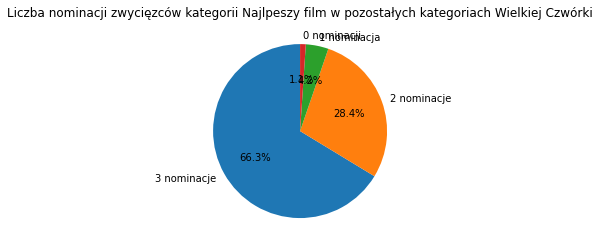

In [30]:
import matplotlib.pyplot as plt

# Dane dla wykresu kołowego
labels = ['3 nominacje', '2 nominacje', '1 nominacja', '0 nominacji']
sizes = [three, two, one, none]

# Utworzenie wykresu kołowego
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Dodanie tytułu
plt.title('Liczba nominacji zwycięzców kategorii Najlpeszy film w pozostałych kategoriach Wielkiej Czwórki')

# Wyświetlenie wykresu
plt.show()

In [73]:
# Count the number of films with nominations in actor
actor_nominations = hot_encoded_win_gender[(hot_encoded_win_gender['Actor'] == 1)].shape[0]
# Count the number of films with nominations in actress
actress_nominations = hot_encoded_win_gender[(hot_encoded_win_gender['Actress'] == 1)].shape[0]
# Count the number of films with nominations for actor and actress
all_nominations = hot_encoded_win_gender[(hot_encoded_win_gender['Actor'] == 1) & (hot_encoded_win_gender['Actress'] == 1)].shape[0]

# Print the results
print("Number of films with nominations for an actor", actor_nominations)
print("Number of films with nominations for actress:", actress_nominations)
print("Number of films with nominations for both actor and actress:", all_nominations)

Number of films with nominations for an actor 55
Number of films with nominations for actress: 28
Number of films with nominations for both actor and actress: 15


In [36]:
# I want to look only into winners nominations
df_noms = df_kaggle[df_kaggle['film'].isin(ocs_winners['film'])].copy()
df_year_noms = df_noms.merge(ocs_winners, left_on='year_film', right_on='year', how='inner')
df_noms_filtered = df_year_noms[df_year_noms['film_x'] == df_year_noms['film_y']].drop(['winner', 'year','name', 'film_y'], axis=1)
df_noms_filtered


,year_film,year_ceremony,ceremony,category,film_x,wiki
0,1927,1928,1,VFX,Wings,/wiki/Wings_(1927_film)
1,1927,1928,1,Best Picture,Wings,/wiki/Wings_(1927_film)
2,1928,1929,2,Actress,The Broadway Melody,/wiki/The_Broadway_Melody
3,1928,1929,2,Directing,The Broadway Melody,/wiki/The_Broadway_Melody
4,1928,1929,2,Best Picture,The Broadway Melody,/wiki/The_Broadway_Melody
...,...,...,...,...,...,...
815,2022,2023,95,Film Editing,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
819,2022,2023,95,Music,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
820,2022,2023,95,Music,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
822,2022,2023,95,Best Picture,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once


In [38]:
# group by Category and aggregate the Year column
df_cats = df_noms.groupby('category')['year_film'].agg(['min', 'max']).reset_index()

# rename columns
df_cats.columns = ['Category', 'Earliest Year', 'Latest Year']
df_cats

,Category,Earliest Year,Latest Year
0,Actor,1930,2018
1,Actor In A Supporting Role,1937,2022
2,Actress,1928,2022
3,Actress In A Supporting Role,1938,2022
4,Assistant Director,1937,1937
5,Best Picture,1927,2022
6,Cinematography,1929,2022
7,Costume Design,1948,2022
8,Dance Direction,1936,1936
9,Directing,1928,2022


In [43]:
general_cats = ['Writing', 'Best Picture', 'Acting', 'Directing', 'Film Editing', 'Music', 'Cinematography', 'Sound', 'Production Design', 'Costume', 'Makeup and Hairstyling', 'VFX']
# im creating a separate df which consists of generalised nominations - all acting into one, got rid of animation, international, short and documenatry
df_main_noms=main_noms(df_noms_filtered, general_cats)
df_main_noms.head(20)

,year_film,year_ceremony,ceremony,category,film_x,wiki
0,1927,1928,1,VFX,Wings,/wiki/Wings_(1927_film)
1,1927,1928,1,Best Picture,Wings,/wiki/Wings_(1927_film)
2,1928,1929,2,Acting,The Broadway Melody,/wiki/The_Broadway_Melody
3,1928,1929,2,Directing,The Broadway Melody,/wiki/The_Broadway_Melody
4,1928,1929,2,Best Picture,The Broadway Melody,/wiki/The_Broadway_Melody
5,1929,1930,3,Cinematography,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(1930_film)
6,1929,1930,3,Directing,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(1930_film)
7,1929,1930,3,Best Picture,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(1930_film)
8,1929,1930,3,Writing,All Quiet on the Western Front,/wiki/All_Quiet_on_the_Western_Front_(1930_film)
9,1930,1931,4,Acting,Cimarron,/wiki/Cimarron_(1931_film)


In [41]:
nominations = df_main_noms.drop_duplicates()
nominations

,year_film,year_ceremony,ceremony,category,film_x,wiki
0,1927,1928,1,VFX,Wings,/wiki/Wings_(1927_film)
1,1927,1928,1,Best Picture,Wings,/wiki/Wings_(1927_film)
2,1928,1929,2,Acting,The Broadway Melody,/wiki/The_Broadway_Melody
3,1928,1929,2,Directing,The Broadway Melody,/wiki/The_Broadway_Melody
4,1928,1929,2,Best Picture,The Broadway Melody,/wiki/The_Broadway_Melody
...,...,...,...,...,...,...
814,2022,2023,95,Directing,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
815,2022,2023,95,Film Editing,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
819,2022,2023,95,Music,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once
822,2022,2023,95,Best Picture,Everything Everywhere All at Once,/wiki/Everything_Everywhere_All_at_Once


In [42]:

n_of_ceremonies = nominations.iloc[-1, 2]
# count the occurrences of each value in the list
value_counts = nominations['category'].value_counts(normalize=False).to_frame().reset_index()


value_counts.columns= ['category','number']
value_counts['percentage'] = (value_counts['number']/n_of_ceremonies).apply(lambda x: '{:.2f}%'.format(x*100))
print(value_counts)
value_counts.to_csv('./nominations.csv', index = False)

            category  number percentage
0       Best Picture      91     95.79%
1          Directing      85     89.47%
2            Writing      84     88.42%
3       Film Editing      75     78.95%
4             Acting      67     70.53%
5     Cinematography      54     56.84%
6              Music      54     56.84%
7  Production Design      45     47.37%
8              Sound      44     46.32%
9                VFX      10     10.53%


In [13]:
#nomintions of the best picture nominees in 2022/2023
df_2022 = df_kaggle[df_kaggle['year_film']==2022]
nominees = ['Everything Everywhere All at Once', 'All uiet on the Western Front', 'Avatar: The Way of Water', 'The Banshees of Inisherin', 'Elvis', 'The Fablemans', 'Tár', 'Top Gun: Maverick', 'Triangle of Sadness', 'Women Talking']
df_2022_bp = df_2022[df_2022['film'].isin(nominees)].reset_index(drop=True).drop(['year_film', 'year_ceremony', 'ceremony'], axis=1)
df_2022_main_noms = main_noms(df_2022_bp, general_cats)
df_2022_main_noms

,category,name,film,winner
0,Acting,Austin Butler,Elvis,False
1,Acting,Colin Farrell,The Banshees of Inisherin,False
5,Acting,Cate Blanchett,Tár,False
6,Acting,Michelle Yeoh,Everything Everywhere All at Once,True
10,Cinematography,Mandy Walker,Elvis,False
11,Cinematography,Florian Hoffmeister,Tár,False
14,Directing,Martin McDonagh,The Banshees of Inisherin,False
15,Directing,Daniel Kwan and Daniel Scheinert,Everything Everywhere All at Once,True
16,Directing,Todd Field,Tár,False
17,Directing,Ruben Östlund,Triangle of Sadness,False


In [22]:
nominations_df = pd.DataFrame(index=nominees, columns=general_cats)
for film in nominees:
    for category in general_cats:
        if not pd.isna(nominations_df.loc[film, category]):
            continue
        if not df_2022_main_noms[(df_2022_main_noms['category'] == category) & (df_2022_main_noms['film'] == film)].empty:
            nominations_df.loc[film, category] = 'Won' if df_2022_main_noms[(df_2022_main_noms['category'] == category) & (df_2022_main_noms['film'] == film)]['winner'].values[0] else 'Nominated'
        else:
            nominations_df.loc[film, category] = 'Not nominated'
nominations_df
nominations_df.to_csv('./nom_win_df.csv')


In [ ]:
import tabulate
from tabulate import tabulate
import pyperclip
# Zamiana wartości w komórkach na kropki i puste komórki
nominations_df.replace({'Won' : '..', 'Nominated': '•', 'Not nominated': ' '}, inplace=True)

# Konwersja DataFrame na tablicę
table = tabulate(nominations_df, headers='keys', tablefmt='grid')
# Copy the table to the clipboard
pyperclip.copy(table)

# Wyświetlenie tabeli
print(table)

In [274]:
# list of current noms
cats_soup = BeautifulSoup(rq.get('https://en.wikipedia.org/wiki/Academy_Awards').text, 'lxml')

# find all caption tags that contain the text 'Population'
caption_tag = cats_soup.find('caption', text=re.compile("List of current Awards of Merit categories by year introduced, sortable by category"))

cats_table = caption_tag.find_parent('table')
print(type(cats_table))
# use the pandas 'read_html()' function to convert the table to a DataFrame
cats_df = pd.read_html(str(cats_table))[0]
categories= cats_df['Category'].values
# print the DataFrame
print(categories)


<class 'bs4.element.Tag'>
['Best Picture' 'Best Director' 'Best Actor' 'Best Actress'
 'Best Cinematography' 'Best Production Design' 'Best Adapted Screenplay'
 'Best Sound' 'Best Animated Short Film' 'Best Live Action Short Film'
 'Best Film Editing' 'Best Original Score' 'Best Original Song'
 'Best Supporting Actor' 'Best Supporting Actress' 'Best Visual Effects'
 'Best Original Screenplay' 'Best Documentary Short Film'
 'Best Documentary Feature Film' 'Best International Feature Film'
 'Best Costume Design' 'Best Makeup and Hairstyling'
 'Best Animated Feature Film']


so oscar categories names changed throughout the years
honorary award is a separate to oscars award given by the board of governors - celbrates acheivements not covered by exisitng academy awards - im dleeting it